<a href="https://colab.research.google.com/github/gabrielfernandorey/GGGR/blob/main/LSTM/SRT%20v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SRT v5 - Ensayo
### LSTM - Nuevo Dataset

In [1]:
import random
import math
import string
import pandas as pd
import numpy as np
from datetime import date

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() # setting seaborn default for plots

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


### Importamos Datos

In [2]:
!wget https://raw.githubusercontent.com/gabrielfernandorey/GGGR/main/alfanumerico_48_SRT.csv

--2023-05-08 17:46:26--  https://raw.githubusercontent.com/gabrielfernandorey/GGGR/main/alfanumerico_48_SRT.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5090965 (4.9M) [text/plain]
Saving to: ‘alfanumerico_48_SRT.csv’

alfanumerico_48_SRT 100%[===================>]   4.85M  --.-KB/s    in 0.04s   

2023-05-08 17:46:26 (113 MB/s) - ‘alfanumerico_48_SRT.csv’ saved [5090965/5090965]



In [3]:
df = pd.read_csv('/content/alfanumerico_48_SRT.csv', header=0, usecols=[1,2,3,4],
                 names=['codigo','año','mes','total_cp'],
                 dtype={'codigo': str, 'año': int, 'mes': int, 'total_cp': int})
df

,codigo,año,mes,total_cp
0,1001,2000,9,1
1,1001,2000,11,1
2,1001,2001,1,1
3,1001,2001,2,1
4,1001,2001,8,1
...,...,...,...,...
199325,9420,2022,11,25
199326,9420,2022,12,26
199327,9420,2023,1,14
199328,9420,2023,2,22


### EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199330 entries, 0 to 199329
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   codigo    199330 non-null  object
 1   año       199330 non-null  int64 
 2   mes       199330 non-null  int64 
 3   total_cp  199330 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 6.1+ MB


### Transformacion

In [5]:
# Columna con fecha en formato date
df['fecha'] = pd.to_datetime({'year': df['año'],
                               'month': df['mes'],
                               'day': '01'})
df

,codigo,año,mes,total_cp,fecha
0,1001,2000,9,1,2000-09-01
1,1001,2000,11,1,2000-11-01
2,1001,2001,1,1,2001-01-01
3,1001,2001,2,1,2001-02-01
4,1001,2001,8,1,2001-08-01
...,...,...,...,...,...
199325,9420,2022,11,25,2022-11-01
199326,9420,2022,12,26,2022-12-01
199327,9420,2023,1,14,2023-01-01
199328,9420,2023,2,22,2023-02-01


In [6]:
# Ordenamos por fecha
df = df.set_index('fecha')
df

,codigo,año,mes,total_cp
fecha,,,,
2000-09-01,1001,2000,9,1
2000-11-01,1001,2000,11,1
2001-01-01,1001,2001,1,1
2001-02-01,1001,2001,2,1
2001-08-01,1001,2001,8,1
...,...,...,...,...
2022-11-01,9420,2022,11,25
2022-12-01,9420,2022,12,26
2023-01-01,9420,2023,1,14


### Visualizacion

In [7]:
unicos = pd.unique(df.codigo)
unicos

array(['1001', '1002', '1003', ..., '9407', '9410', '9420'], dtype=object)

In [8]:
codigo_in = random.choice(unicos) 
codigo_in

'7540'

In [9]:
filtro = df[df.codigo == codigo_in]
filtro

,codigo,año,mes,total_cp
fecha,,,,
2003-07-01,7540,2003,7,1
2004-12-01,7540,2004,12,1
2005-04-01,7540,2005,4,3
2005-06-01,7540,2005,6,1
2005-10-01,7540,2005,10,1
...,...,...,...,...
2022-11-01,7540,2022,11,4
2022-12-01,7540,2022,12,1
2023-02-01,7540,2023,2,8


In [10]:
filtro.tail(1).index[0]

Timestamp('2023-04-01 00:00:00')

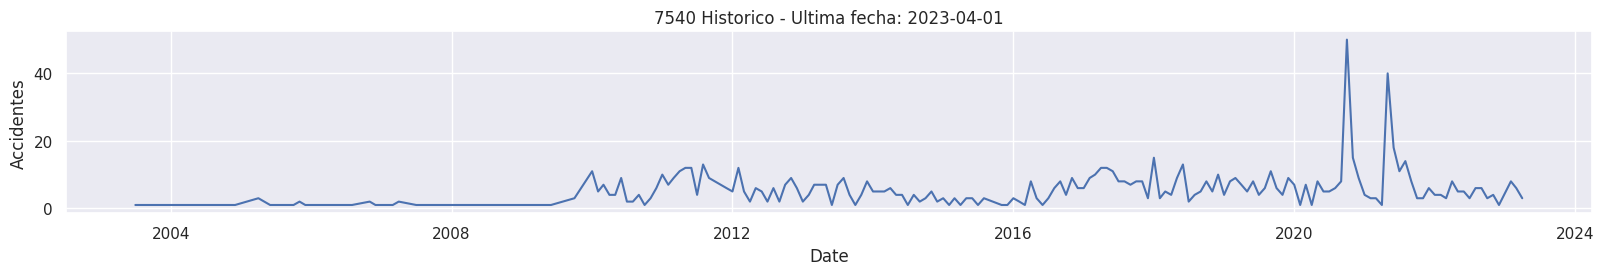

In [11]:
cm = 1/2.54  # centimeters in inches
plt.subplots(figsize=(50*cm, 6*cm))
plt.title(str(codigo_in) +' Historico'+' - Ultima fecha: '+ str(filtro.tail(1).index[0])[:10])
plt.plot(filtro['total_cp'])
plt.xlabel('Date', fontsize=12)
plt.ylabel('Accidentes', fontsize=12);

### Preparamos datos

In [12]:
data = filtro.filter(['total_cp'])

In [13]:
# Convertimos a numpy array
dataset = data.values
len(dataset)

179

### Transformar la variable de salida

In [14]:
mmscaler = MinMaxScaler()

In [15]:
data_scaled = mmscaler.fit_transform(dataset)

### Pre-entrenamiento

In [16]:
# Calculamos cantidad de datos para training y para test
training_data_len = math.ceil(len(dataset) * .8)
training_data_len 

144

In [17]:
# Prepara datos de entrenamiento
train_data = data_scaled[0:training_data_len, : ]
len(train_data)

144

In [18]:
periodo = 48
X_train = []
y_train = []

for i in range(periodo, len(train_data)):
    X_train.append(train_data[i-periodo:i, 0])
    y_train.append(train_data[i, 0])


In [19]:
#Convertir a numpy
X_train, y_train = np.array(X_train), np.array(y_train)

In [20]:
X_train.shape

(96, 48)

In [21]:
#Reshape 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(96, 48, 1)

### Modelo

In [22]:
dim_entrada = (X_train.shape[1], 1)  # dimension periodo
dim_salida = 1

modelo = Sequential()
modelo.add(LSTM(units=25, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))

In [23]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25)                2700      
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 2,726
Trainable params: 2,726
Non-trainable params: 0
_________________________________________________________________


In [24]:
modelo.compile(optimizer='rmsprop', loss='mse')

In [25]:
modelo.fit(X_train, y_train, epochs=20, batch_size=16, )

Epoch 1/20
6/6 [==============================] - 2s 18ms/step - loss: 0.0044
Epoch 2/20
6/6 [==============================] - 0s 14ms/step - loss: 0.0037
Epoch 3/20
6/6 [==============================] - 0s 16ms/step - loss: 0.0035
Epoch 4/20
6/6 [==============================] - 0s 15ms/step - loss: 0.0035
Epoch 5/20
6/6 [==============================] - 0s 15ms/step - loss: 0.0035
Epoch 6/20
6/6 [==============================] - 0s 15ms/step - loss: 0.0035
Epoch 7/20
6/6 [==============================] - 0s 15ms/step - loss: 0.0037
Epoch 8/20
6/6 [==============================] - 0s 14ms/step - loss: 0.0034
Epoch 9/20
6/6 [==============================] - 0s 15ms/step - loss: 0.0035
Epoch 10/20
6/6 [==============================] - 0s 15ms/step - loss: 0.0035
Epoch 11/20
6/6 [==============================] - 0s 17ms/step - loss: 0.0035
Epoch 12/20
6/6 [==============================] - 0s 14ms/step - loss: 0.0035
Epoch 13/20
6/6 [==============================] - 0s 15ms/st

### Prediccion

In [26]:
# Ultimos valores   del dataframe a array
last_days_scaled = data_scaled[-periodo:, : ]

In [27]:
len(data_scaled), len(last_days_scaled)

(179, 48)

In [28]:
X_test_new = []
X_test_new.append(last_days_scaled)
X_test_new = np.array(X_test_new)
X_test_new = np.reshape(X_test_new, (1, periodo, 1))  # Entramos con un 1 vector de dimension 'periodo'

In [29]:
pred = modelo.predict(X_test_new)
pred = mmscaler.inverse_transform(pred)

1/1 [==============================] - 1s 705ms/step


In [40]:
print(f"Prediccion para el código {codigo_in} para la fecha {str(filtro.tail(1).index[0]+pd.DateOffset(months=1))[:10]}: {round(pred[0][0])} incidentes")  

Prediccion para el código 7540 para la fecha 2023-05-01: 5 incidentes


### Visualizar

In [31]:
X_test_new = np.reshape(X_test_new, (1, periodo))

In [32]:
last = mmscaler.inverse_transform(X_test_new)

In [33]:
df_incidentes = pd.DataFrame(last)

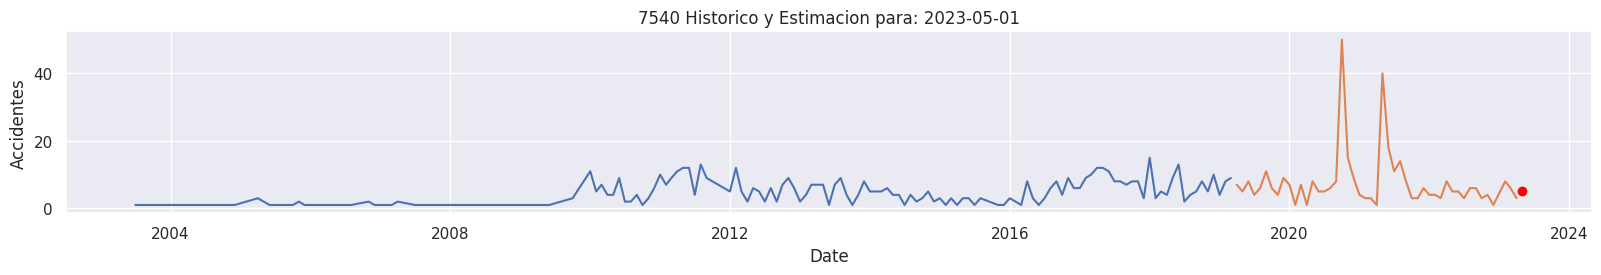

In [39]:
plt.subplots(figsize=(50*cm, 6*cm))
plt.title(str(codigo_in) +' Historico y Estimacion para: '+ str(filtro.tail(1).index[0]+pd.DateOffset(months=1))[:10])
plt.plot(data[:-periodo])
plt.plot(data[-periodo:])
plt.scatter([filtro.tail(1).index[0]+pd.DateOffset(months=1)], round(pred[0][0]), color='red')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Accidentes', fontsize=12);

In [35]:
# Ultimos incidentes
df_incidentes

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,7.0,5.0,8.0,4.0,6.0,11.0,6.0,4.0,9.0,7.0,...,5.0,3.0,6.0,6.0,3.0,4.0,1.0,8.0,6.0,3.0


In [41]:
data[-48:]

,total_cp
fecha,
2019-04-01,7
2019-05-01,5
2019-06-01,8
2019-07-01,4
2019-08-01,6
2019-09-01,11
2019-10-01,6
2019-11-01,4
2019-12-01,9


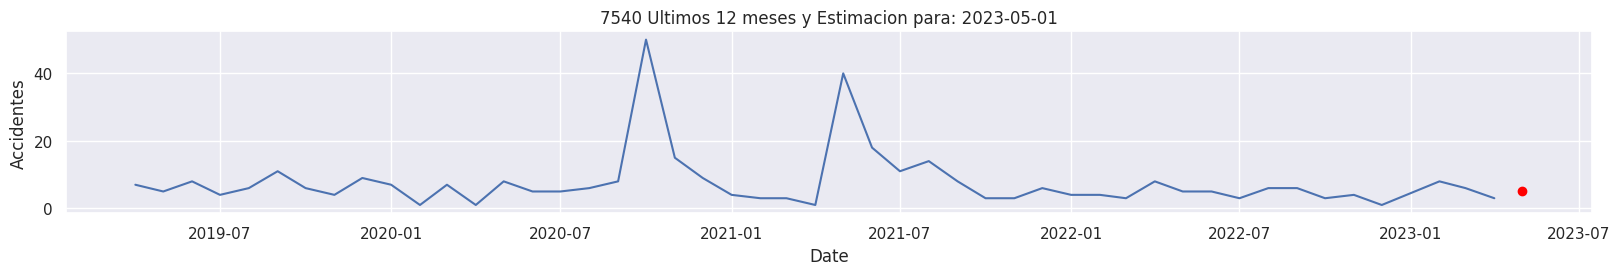

In [44]:
plt.subplots(figsize=(50*cm, 6*cm))
plt.title(str(codigo_in) +' Ultimos 48 meses y Estimacion para: '+ str(filtro.tail(1).index[0]+pd.DateOffset(months=1))[:10])
plt.plot(data[-48:])
plt.scatter([filtro.tail(1).index[0]+pd.DateOffset(months=1)], round(pred[0][0]), color='red')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Accidentes', fontsize=12);

### Compacto

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 14.5 µs
Epoch 1/20
6/6 [==============================] - 3s 20ms/step - loss: 0.0067
Epoch 2/20
6/6 [==============================] - 0s 19ms/step - loss: 0.0038
Epoch 3/20
6/6 [==============================] - 0s 18ms/step - loss: 0.0038
Epoch 4/20
6/6 [==============================] - 0s 20ms/step - loss: 0.0039
Epoch 5/20
6/6 [==============================] - 0s 20ms/step - loss: 0.0037
Epoch 6/20
6/6 [==============================] - 0s 23ms/step - loss: 0.0037
Epoch 7/20
6/6 [==============================] - 0s 21ms/step - loss: 0.0037
Epoch 8/20
6/6 [==============================] - 0s 16ms/step - loss: 0.0036
Epoch 9/20
6/6 [==============================] - 0s 20ms/step - loss: 0.0037
Epoch 10/20
6/6 [==============================] - 0s 19ms/step - loss: 0.0036
Epoch 11/20
6/6 [==============================] - 0s 22ms/step - loss: 0.0036
Epoch 12/20
6/6 [==============================] - 0s 20ms/step - loss: 0.00

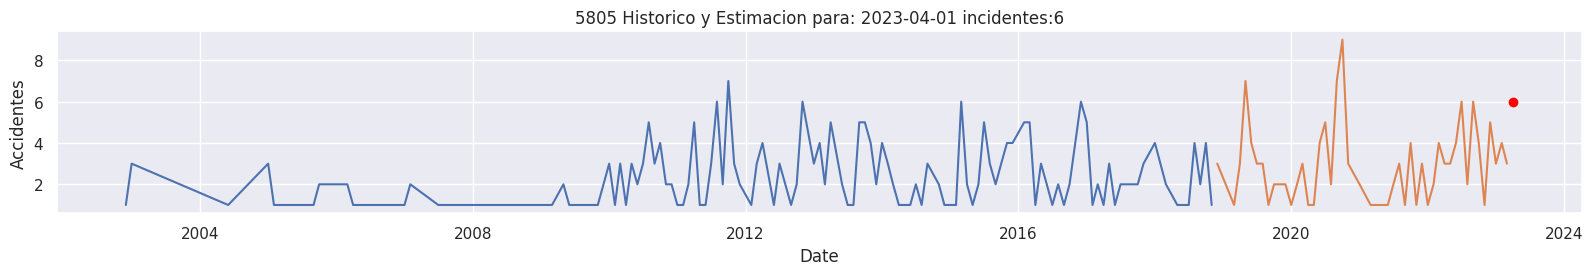

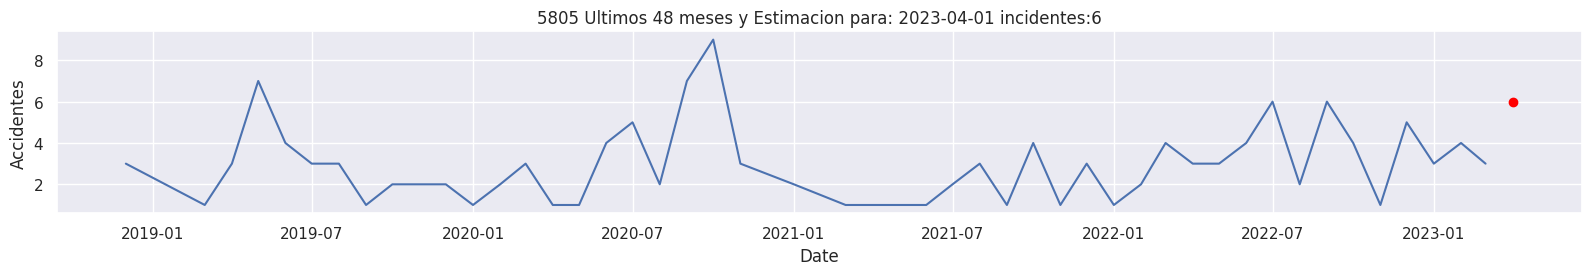

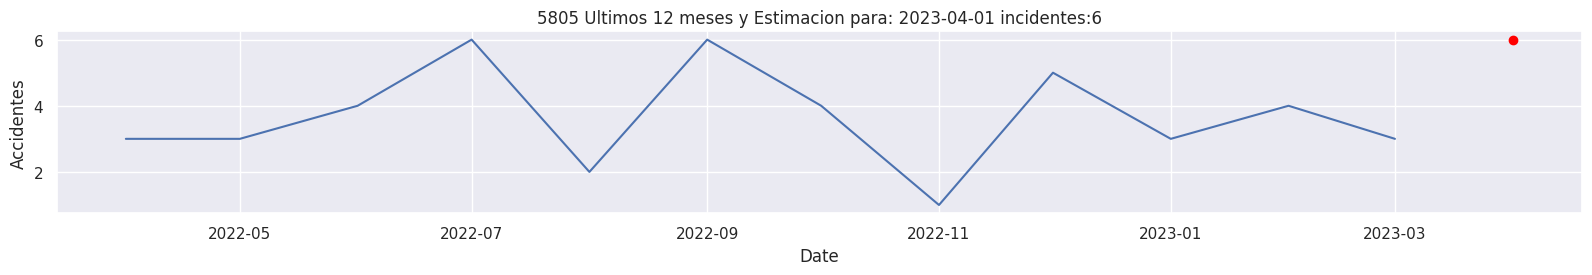

In [59]:
%time
codigo_in = random.choice(unicos) 
filtro = df[df.codigo == codigo_in]
data = filtro.filter(['total_cp'])
data_scaled = mmscaler.fit_transform(dataset)
training_data_len = math.ceil(len(dataset) * .8)
train_data = data_scaled[0:training_data_len, : ]

periodo = 48
X_train = []
y_train = []

for i in range(periodo, len(train_data)):
    X_train.append(train_data[i-periodo:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
dim_entrada = (X_train.shape[1], 1)  
dim_salida = 1

modelo = Sequential()
modelo.add(LSTM(units=25, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')
modelo.fit(X_train, y_train, epochs=20, batch_size=16)

last_days_scaled = data_scaled[-periodo:, : ]
X_test_new = []
X_test_new.append(last_days_scaled)
X_test_new = np.array(X_test_new)
X_test_new = np.reshape(X_test_new, (1, periodo, 1))

pred = modelo.predict(X_test_new)
pred = mmscaler.inverse_transform(pred)
print(f"Prediccion para el código {codigo_in} para la fecha {str(filtro.tail(1).index[0]+pd.DateOffset(months=1))[:10]}: {round(pred[0][0])} incidentes")  

X_test_new = np.reshape(X_test_new, (1, periodo))
last = mmscaler.inverse_transform(X_test_new)
df_incidentes = pd.DataFrame(last)

plt.subplots(figsize=(50*cm, 6*cm))
plt.title(str(codigo_in) +' Historico y Estimacion para: '+ str(filtro.tail(1).index[0]+pd.DateOffset(months=1))[:10] + ' incidentes:' + str(round(pred[0][0])))
plt.plot(data[:-periodo])
plt.plot(data[-periodo:])
plt.scatter([filtro.tail(1).index[0]+pd.DateOffset(months=1)], round(pred[0][0]), color='red')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Accidentes', fontsize=12);

plt.subplots(figsize=(50*cm, 6*cm))
plt.title(str(codigo_in) +' Ultimos 48 meses y Estimacion para: '+ str(filtro.tail(1).index[0]+pd.DateOffset(months=1))[:10] + ' incidentes:' + str(round(pred[0][0])))
plt.plot(data[-48:])
plt.scatter([filtro.tail(1).index[0]+pd.DateOffset(months=1)], round(pred[0][0]), color='red')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Accidentes', fontsize=12);

plt.subplots(figsize=(50*cm, 6*cm))
plt.title(str(codigo_in) +' Ultimos 12 meses y Estimacion para: '+ str(filtro.tail(1).index[0]+pd.DateOffset(months=1))[:10] + ' incidentes:' + str(round(pred[0][0])))
plt.plot(data[-12:])
plt.scatter([filtro.tail(1).index[0]+pd.DateOffset(months=1)], round(pred[0][0]), color='red')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Accidentes', fontsize=12);